In [1]:
import pandas as pd
from pylab import *
from keras.models import Layer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorboard as tb

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
import preprocessors as prep

In [4]:
train_file_path = './data.csv'

In [271]:
train_df = pd.read_csv(train_file_path)

In [272]:
train_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,04-10-2010,20501.21094,20706.74023,20437.35938,20475.73047,20475.73047,15000
1,05-10-2010,20461.98047,20560.53906,20383.16016,20407.71094,20407.71094,17800
2,06-10-2010,20448.68945,20669.94922,20447.05078,20543.08008,20543.08008,16200
3,07-10-2010,20544.30078,20581.28906,20272.76953,20315.32031,20315.32031,19200
4,08-10-2010,20297.58008,20409.18945,20145.74023,20250.25977,20250.25977,15400


In [273]:
train_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1973,26-09-2018,36936.64063,36938.73828,36357.92969,36542.26953,36542.26953,21800
1974,27-09-2018,36691.92969,36711.62109,36238.23047,36324.17188,36324.17188,17800
1975,28-09-2018,36452.73828,36551.85938,35985.62891,36227.14063,36227.14063,22800
1976,01-10-2018,36274.25,36616.64063,35960.64844,36526.14063,36526.14063,21300
1977,03-10-2018,36602.85156,36602.85156,35911.82031,35975.62891,35975.62891,25100


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 7 columns):
Date         1978 non-null object
Open         1978 non-null object
High         1978 non-null object
Low          1978 non-null object
Close        1978 non-null object
Adj Close    1978 non-null object
Volume       1978 non-null object
dtypes: object(7)
memory usage: 108.2+ KB


In [8]:
train_df[train_df.columns[0]] = pd.to_datetime(train_df[train_df.columns[0]])

In [9]:
train_df.dtypes

Date         datetime64[ns]
Open                 object
High                 object
Low                  object
Close                object
Adj Close            object
Volume               object
dtype: object

In [10]:
train_df.index = train_df[train_df.columns[0]]

In [11]:
del train_df[train_df.columns[0]]

In [12]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-04-10,20501.21094,20706.74023,20437.35938,20475.73047,20475.73047,15000
2010-05-10,20461.98047,20560.53906,20383.16016,20407.71094,20407.71094,17800
2010-06-10,20448.68945,20669.94922,20447.05078,20543.08008,20543.08008,16200
2010-07-10,20544.30078,20581.28906,20272.76953,20315.32031,20315.32031,19200
2010-08-10,20297.58008,20409.18945,20145.74023,20250.25977,20250.25977,15400


In [13]:
cols = train_df.columns[train_df.dtypes.eq(object)]
train_df[cols] = train_df[cols].apply(pd.to_numeric, errors='coerce', axis=0)

In [14]:
train_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [15]:
train_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-04-10,20501.21094,20706.74023,20437.35938,20475.73047,20475.73047,15000.0
2010-05-10,20461.98047,20560.53906,20383.16016,20407.71094,20407.71094,17800.0
2010-06-10,20448.68945,20669.94922,20447.05078,20543.08008,20543.08008,16200.0
2010-07-10,20544.30078,20581.28906,20272.76953,20315.32031,20315.32031,19200.0
2010-08-10,20297.58008,20409.18945,20145.74023,20250.25977,20250.25977,15400.0


In [16]:
train_df.sort_index(inplace=True)

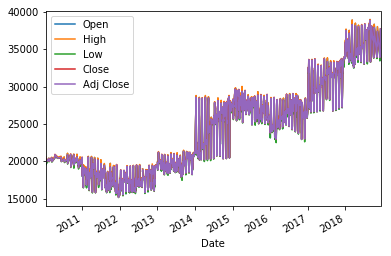

In [17]:
train_df[train_df.columns[:-1]].plot()
plt.show()

In [18]:
train_df.fillna(method='backfill',inplace=True)

# Data Preprocessing Done

In [207]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from keras.optimizers import  Adam
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [208]:
# convert time series into supervised learning problem
def data_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [209]:
def exp_smoothing(data,EMA = 0.0,gamma = 0.5):
    # So the data will have a smoother curve than the original ragged data
    EMA = 0.0
    gamma = 0.5
    for col in range(data.shape[-1]):
        for ti in range(len(data)):
            EMA = gamma*data[ti,col] + (1-gamma)*EMA
            data[ti,col] = EMA
    return data

In [237]:
# transform df into train and test sets for supervised learning
def prepare_data(df,n_lag, n_seq_forecast,test_frac=0.2):
    # extract raw values
    raw_values = df.values
#     raw_values = exp_smoothing(raw_values)
    # transform data to be stationary
#     diff_values = prep.differencing(raw_values,axis=0)
    # rescale values to -1, 1
    scaled_values,scaler = prep.normalise_standardise(raw_values)
    # transform into supervised learning problem X, y
    supervised = data_to_supervised(scaled_values, n_lag, n_seq_forecast)
    print("Supervised Data :\n {} \n {}".format(supervised.shape,supervised.head()))
    supervised_values = supervised.values
    # split into train and test sets
    train, test = prep.split_the_data(supervised_values,test_frac=test_frac)
    train  = exp_smoothing(train)
    return scaler, train, test

In [238]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size),:]
        data_X.append(a)
        data_Y.append(dataset[i + window_size,:])
    return(np.array(data_X), np.array(data_Y))

In [239]:
#Dimensionality of the data. Since your data is 1-D this would be 1
no_of_input_features = train_df.shape[-1]
# Number of time steps you look into the future.
window_size = 20
batch_size = 16           # Number of samples in a batch
no_epochs = 100            # No of epochs
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.5           # dropout amount
n_lag = 4
n_seq_forecast = 1

In [240]:
scaler,train_data,test_data = prepare_data(train_df,n_seq_forecast=n_seq_forecast,n_lag=n_lag)

Supervised Data :
 (1974, 30) 
    var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var6(t-4)  \
4  -1.000000   0.116771   0.137720   0.118028   0.129887  -0.858660   
5  -0.672252  -0.257526  -0.248588  -0.248696  -0.242767  -0.885027   
6  -0.477773  -0.421849  -0.409321  -0.410822  -0.407857  -0.906029   
7  -0.393391  -0.518369  -0.505283  -0.507008  -0.505525  -0.901762   
8  -0.336050  -0.547094  -0.531478  -0.534835  -0.534093  -0.928296   

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)    ...     var3(t-1)  var4(t-1)  \
4  -0.672252  -0.257526  -0.248588  -0.248696    ...     -0.505283  -0.507008   
5  -0.477773  -0.421849  -0.409321  -0.410822    ...     -0.531478  -0.534835   
6  -0.393391  -0.518369  -0.505283  -0.507008    ...     -0.568104  -0.570118   
7  -0.336050  -0.547094  -0.531478  -0.534835    ...     -0.562409  -0.565962   
8  -0.323603  -0.581698  -0.568104  -0.570118    ...     -0.552351  -0.545983   

   var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t) 

In [241]:
# Create test and training sets for 20-step-ahead regression.
# reshape training into [samples, timesteps, features]
train_X, train_Y = train_data[:, 0:(no_of_input_features*n_lag)], train_data[:,(no_of_input_features*n_lag):]
train_X = train_X.reshape(train_X.shape[0],n_lag,no_of_input_features)
train_Y = train_Y.reshape(train_Y.shape[0],n_seq_forecast,no_of_input_features)

test_X, test_Y = test_data[:, 0:(no_of_input_features*n_lag)], test_data[:, no_of_input_features*n_lag:]
test_X = np.reshape(test_X, (test_X.shape[0],n_lag,no_of_input_features))
test_Y = test_Y.reshape(test_Y.shape[0],n_seq_forecast,no_of_input_features)

In [242]:
print("Training data input shape: {} and  Output shape: {}".format(train_X.shape,train_Y.shape))
print("Test data input shape: {} and Output shape: {}".format(test_X.shape,test_Y.shape))

Training data input shape: (1580, 4, 6) and  Output shape: (1580, 1, 6)
Test data input shape: (395, 4, 6) and Output shape: (395, 1, 6)


In [243]:
filepath = './best_model'

In [244]:
model_ckpt = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, 
                                save_best_only=False, 
                                save_weights_only=False, 
                                mode='auto', 
                                period=1)

In [245]:
earlystp = EarlyStopping(monitor='val_loss',
                         min_delta=0, 
                         patience=20, 
                         verbose=1, mode='auto')

In [246]:
def lr_decay(epoch):
    initial_lr = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lr= initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

In [247]:
lrscheduler = LearningRateScheduler(lr_decay,verbose=1)

In [248]:
tb = TensorBoard(log_dir='./logs', 
                 histogram_freq=0, batch_size=batch_size)

In [249]:
# fit an LSTM network to training data
def create_model(n_lag,batch_size, num_nodes):
    # training into [samples, timesteps, features]
    # design network
    model = Sequential()
    model.add(LSTM(200,input_shape=(n_lag,no_of_input_features),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200,return_sequences=False))
    model.add(Dropout(0.3))
#     model.add(LSTM(100))
#     model.add(Dropout(0.5))
    model.add(Dense(no_of_input_features*n_seq_forecast))
    model.add(Activation("linear"))
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-7, amsgrad=False)

    model.compile(loss='mean_squared_error', optimizer=adam)
    
    model.summary()
    return model

In [250]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

In [251]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = forecasts[i]
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        
#         # invert differencing
#         index = len(series) - n_test + i - 1
#         last_ob = series.values[index]
#         inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_scale)
    
    return np.array(inverted).reshape(-1,n_seq_forecast,no_of_input_features)

In [252]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq_forecasts):
    for i in range(n_seq_forecasts):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

In [253]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    print(forecasts.shape)
    # plot the entire dataset in blue
    plt.plot(series.values[0])
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s][0]] + forecasts[i]
        plt.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [254]:
model1 = create_model(n_lag=n_lag,batch_size=batch_size,num_nodes=num_nodes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 4, 200)            165600    
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 200)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 1206      
_________________________________________________________________
activation_9 (Activation)    (None, 6)                 0         
Total params: 487,606
Trainable params: 487,606
Non-trainable params: 0
_________________________________________________________________


In [255]:
# Fit the model.
model1.fit(train_X, 
          train_Y.reshape(len(train_Y),-1), 
          batch_size = batch_size,
          epochs = no_epochs,
          validation_split = 0.2,
          verbose=1,shuffle = False,
          callbacks = [model_ckpt,tb,earlystp])

Train on 1264 samples, validate on 316 samples
Epoch 1/100
1264/1264 [==============================] - 5s 4ms/step - loss: 0.0395 - val_loss: 0.0214
Epoch 2/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0446 - val_loss: 0.0140
Epoch 3/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0423 - val_loss: 0.0137
Epoch 4/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0209 - val_loss: 0.0103
Epoch 5/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0210 - val_loss: 0.0051
Epoch 6/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0159 - val_loss: 0.0087
Epoch 7/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0279 - val_loss: 0.0067
Epoch 8/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0259 - val_loss: 0.0143
Epoch 9/100
1264/1264 [==============================] - 3s 2ms/step - loss: 0.0344 - val_loss: 0.0041
Epoch 10/100
1264/1264 [==

In [256]:
def forecast(model,X,batch_size):
    return (model.predict(X,batch_size=batch_size).reshape(-1,n_seq_forecast,no_of_input_features))

In [257]:
# make forecasts
forecasts = forecast(model1,test_X,batch_size=batch_size)
# inverse transform forecasts and test_data
n_test = len(test_X)
# forecasts = scaler.inverse_transform(forecasts)
# actual = scaler.inverse_transform(test_Y)
forecasts = inverse_transform(train_df, forecasts, scaler, n_test+2)
actual = inverse_transform(train_df, test_Y, scaler, n_test+2)

In [258]:
# evaluate forecasts
evaluate_forecasts(test_Y, forecasts, n_lag, n_seq_forecast)

t+1 RMSE: 29099.602209


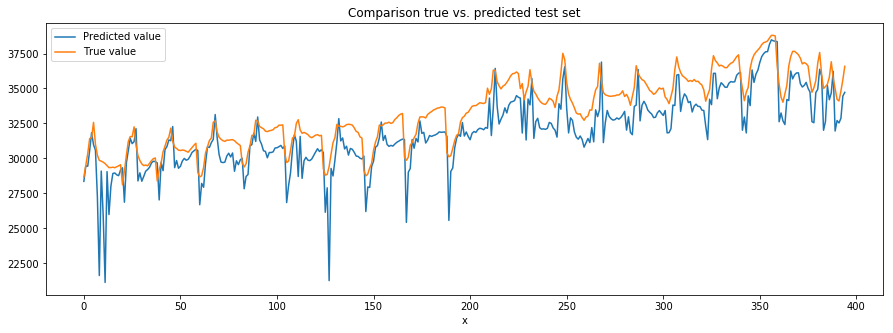

In [259]:
plt.figure(figsize = (15, 5))
# plt.plot(actual[:,0,0], label="True value")
plt.plot(forecasts[:,0,0],label="Predicted value")
plt.plot(actual[:,0,0],label="True value")
plt.xlabel("x")
plt.title("Comparison true vs. predicted test set")
plt.legend()
plt.show()

In [263]:
forecasts[-1,0,0]

34723.516

In [264]:
actual[-1,0,0]

36582.971408994737

In [268]:
train_df.iloc[-1,0]

36582.971408994737

In [270]:
train_df.index[-1]

Timestamp('2018-12-09 00:00:00')

In [260]:
# def predict_and_score(model, X, Y):
#     # Make predictions on the original scale of the data.
#     pred = scaler.inverse_transform(model.predict(X))
#     # Prepare Y data to also be on the original scale for interpretability.
#     orig_data = scaler.inverse_transform(Y)
#     # Calculate RMSE.
#     score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
#     return(score, pred)

# # rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
# rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

# print("Training data score: %.2f RMSE" % rmse_train)
# print("Test data score: %.2f RMSE" % rmse_test)

In [261]:
# Predict on train data.
pred_train = model1.predict(train_X).reshape(-1,n_seq_forecast,no_of_input_features)

# Apply inverse transformation to get back true values.
train_y_actual = scaler.inverse_transform(train_Y[:,0,:])
pred_train_rescaled = scaler.inverse_transform(pred_train[:,0,:])

mse_error_per_op = (mean_squared_error(train_y_actual,pred_train_rescaled,multioutput='raw_values'))
print(mse_error_per_op)

[  1537911.70779712   1445281.90210609   1404711.50379075
   1397631.11139407   1438177.31841029  21419711.82411122]


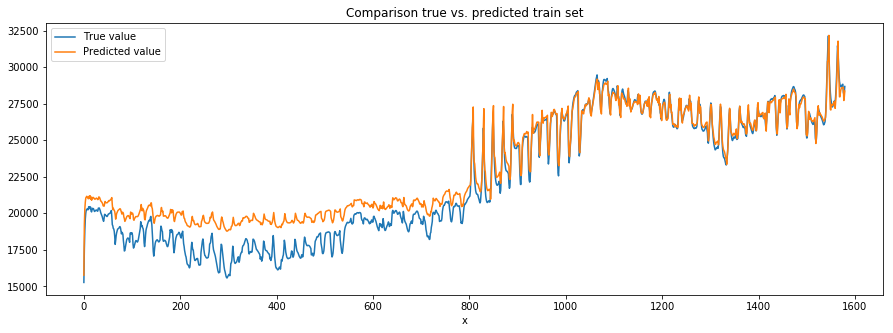

In [262]:
plt.figure(figsize = (15, 5))
plt.plot(train_y_actual[:,0], label="True value")
plt.plot(pred_train_rescaled[:,0], label="Predicted value")
plt.xlabel("x")
plt.title("Comparison true vs. predicted train set")
plt.legend()
plt.show()